In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [2]:
T = 5      # правый конец в годах
eps1 = 3  # естественный прирост жертв в отсутствии хищнков
eps2 = 2 # естественная убыль хищников в отсутствии жертв
q = 1000     # количетсво точек рассмотрения (размер сетки)

r1 = 10
r2 = 20
c1 = 5
c2 = 15
d1 = 6
d2 = 20
M1 = 10
M2 = 21
A1 = 50
A2 = 50

A = 100000

gamma2 = 0.15
gamma3 = 0.1

lambda0 = 1 # = 1 в задаче на минимум

epsilon = 1e-3

78.0
40.0
58658.374140126034
63528.99618137602
63528.99618137602
1
time passed:	 0.078  с


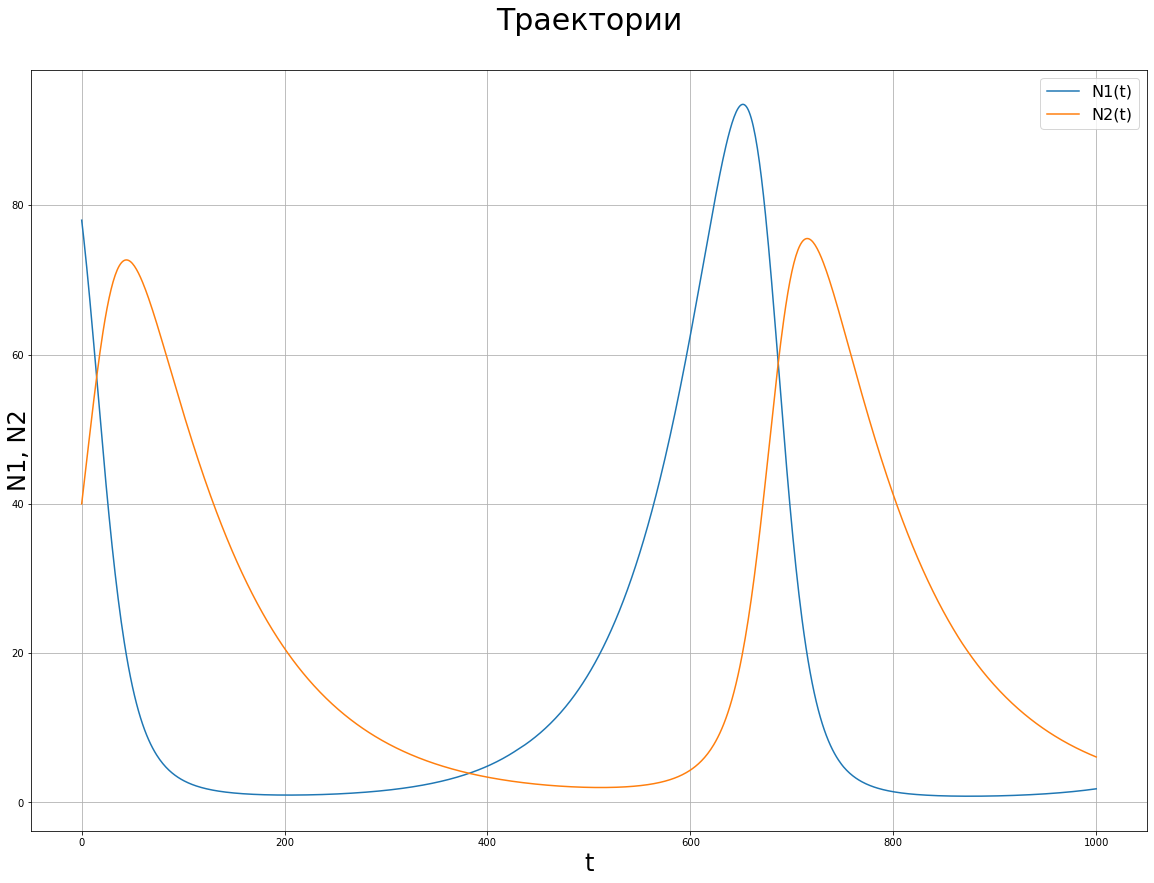

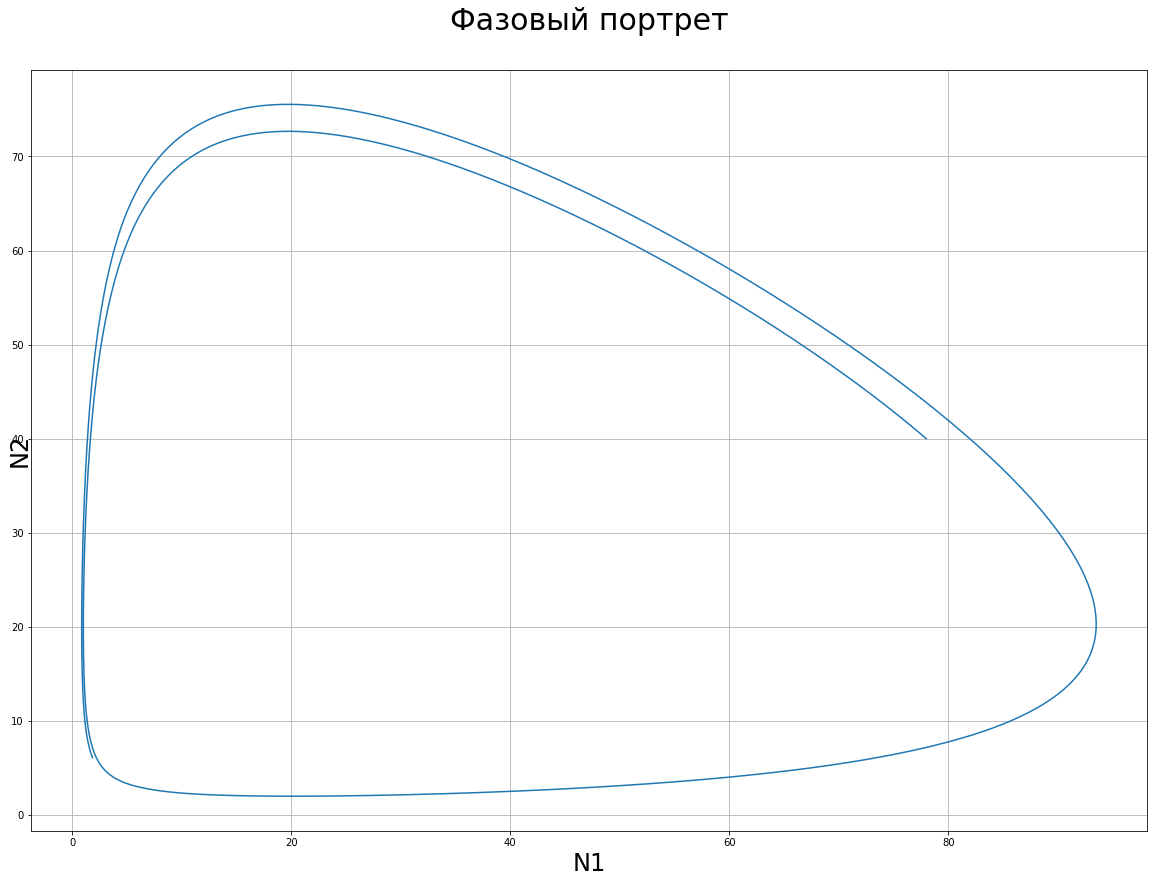

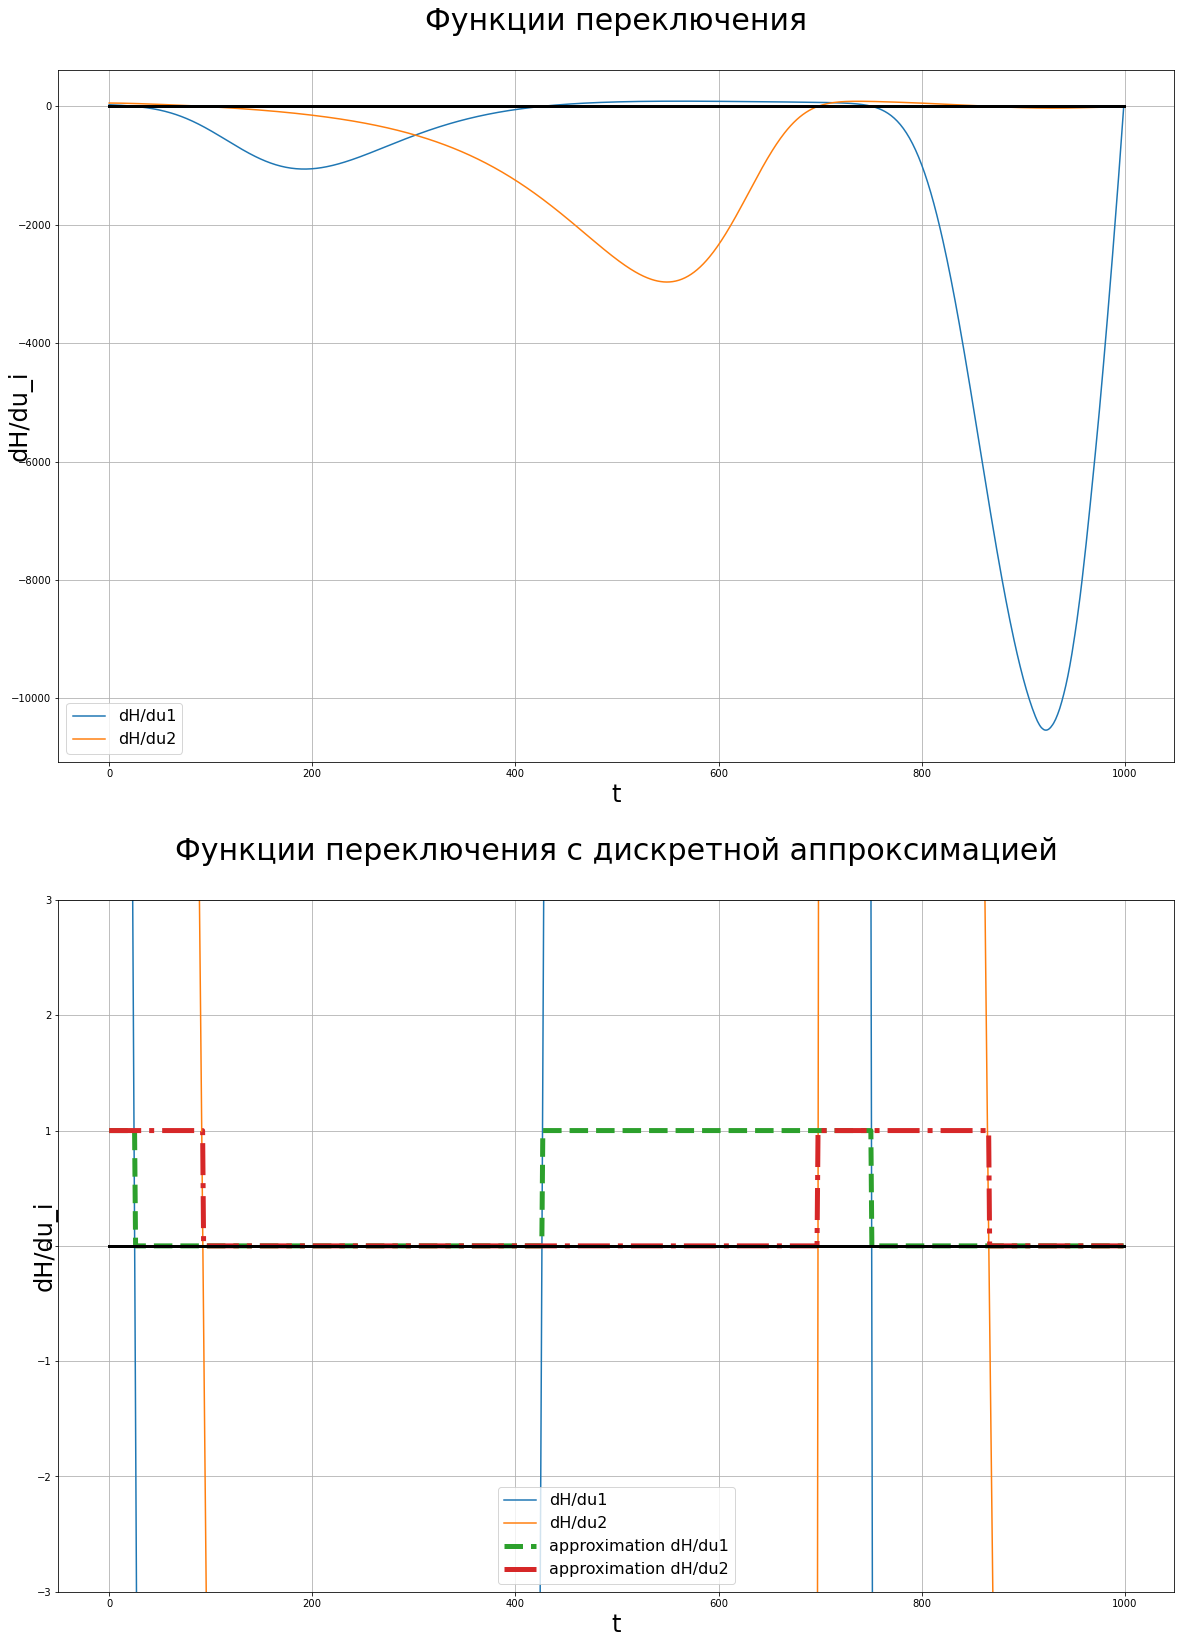

In [9]:
def q_sum(U1, U2, N1, N2): #I,q,r1,c1,r2,c2,U1,U2):
    I = 0
    tmp = 0
    for i in range(0,q):
        I += ((r1 - c1)*U1[i] + (r2 - c2)*U2[i]) * dt
        if i != 0:
            tmp += max(-N1[i],0)**2*dt + max(-N2[i],0)**2*dt
    tmp *= A
    I *= -lambda0 
    I -= lambda0*(d1*N1[q] + d2*N2[q]) - (M1*(N1[q]-A1)**2 + M2*(N2[q]-A2)**2)# - ...еще интеграл (сумма )
    I += tmp
    print(I)
    return I

def gradientDescent(u1, u2, p1, p2, a, eps):
    for i in range(0,q):

        u1[i] = u1[i] - a*(-dt*lambda0*(r1-c1) + dt*p1[i+1])
        u2[i] = u2[i] - a*(-dt*lambda0*(r2-c2) + dt*p2[i+1])
        
        if u1[i] > u_limits[1]:
            u1[i] = u_limits[1]
        if u1[i] < u_limits[0]:
            u1[i] = u_limits[0]
        if u2[i] > u_limits[1]:
            u2[i] = u_limits[1]
        if u2[i] < u_limits[1]:
            u2[i] = u_limits[0]
    
    return u1, u2

u_limits = (0,1) # множества U_i - ограничение на управление
U1 = np.random.uniform(u_limits[0], u_limits[1], size = q)
U2 = np.random.uniform(u_limits[0], u_limits[1], size = q)
#print(U1)

#3) Строим начальную траекторию [x]0, x_i из R_n, i=0,1,...,q
N1_0 = np.random.randint(10, 100)
N2_0 = np.random.randint(5, 50)
N1 = np.zeros(q+1) #, dtype = int)
N2 = np.zeros(q+1) #, dtype = int)
N1[0] = N1_0
N2[0] = N2_0
print(N1[0])
print(N2[0])

dt = T/q

for i in range(0,q):
    N1[i+1] = N1[i] + dt * (eps1*N1[i] - gamma2*N1[i]*N2[i] - U1[i])
    N2[i+1] = N2[i] + dt * (-eps2*N2[i] + gamma3*N1[i]*N2[i] - U2[i])

I = q_sum(U1,U2,N1,N2)

first=time.time()

I_old = I 
N1_old = N1
N2_old = N2
U1_old = U1
U2_old = U2
p1 = np.zeros(q+1)
p2 = np.zeros(q+1)

k = 0
alfa = 10

while (abs(I - I_old) >= epsilon or k == 0):# and k <= 1e3:

    k += 1

    I_old = I
    N1_old = N1
    N2_old = N2
    U1_old = U1
    U2_old = U2

    #7) сопряженные функции
    p1[q] = lambda0*d1 - 2*M1*(N1[q]-A1)
    p2[q] = lambda0*d2 - 2*M2*(N2[q]-A2)
    for i in range(q-1,-1,-1):
        p1[i] = p1[i+1]*(1 + dt*eps1 - dt*N2[i]*gamma2) + p2[i+1]*dt*gamma3*N2[i] + 2*A*max(-N1[i],0) # еще член с A с чертой (+2A'N1(i+) - это max)
        p2[i] = p2[i+1]*(1 - dt*eps2 + dt*N1[i]*gamma3) - p1[i+1]*dt*gamma2*N1[i] + 2*A*max(-N2[i],0) # еще член с A с чертой

    #print("-------------------------------")
    k1 = 0
    while I > I_old or k1 == 0:
        #8) Новое управление
        #print("a")

        I_old = I
        N1_old = N1
        N2_old = N2
        U1_old = U1
        U2_old = U2

        k1 += 1
        U1, U2 = gradientDescent(U1,U2,p1,p2,alfa,1e-3)
        #print(U2)

        #9) новые траектории
        for i in range(0,q):
            N1[i+1] = N1[i] + dt * (eps1*N1[i] - gamma2*N1[i]*N2[i] - U1[i])
            N2[i+1] = N2[i] + dt * (-eps2*N2[i] + gamma3*N1[i]*N2[i] - U2[i])
        #print("N1___",k,"____",N1)

        #10) I_k
        I = q_sum(U1,U2,N1,N2)
        #print(I-I_old)

        alfa /= 2
        #print(alfa)

    #print(k1)

print(k)
#print("\n\n\nI=",I,"\nN1=",N1,"\np1=",p1,"\nU1=",U1)

delta=time.time()-first
print("time passed:\t", round(delta,3), " с")

fig1, au1 = plt.subplots()
q_ar = []
for i in range(0,q+1):
    q_ar.append(i)

au1.plot(q_ar, N1, label='N1(t)')
au1.plot(q_ar, N2, label='N2(t)')
au1.set_xlabel('t', fontsize=24)
au1.set_ylabel('N1, N2', fontsize=24, verticalalignment = "top")
au1.set_title("Траектории\n", fontsize=30)
au1.legend(fontsize = 16)
au1.grid()
fig1.set_figwidth(20)
fig1.set_figheight(14)
plt.show()

fig, au = plt.subplots()
au.plot(N1, N2)
au.set_xlabel('N1', fontsize=24)
au.set_ylabel('N2', fontsize=24, verticalalignment = "top")
au.set_title("Фазовый портрет\n", fontsize=30)
au.grid()
fig.set_figwidth(20)
fig.set_figheight(14)
plt.show()

fig2, (au2, au3) = plt.subplots(2,1)
perecl1 = []
perecl2 = []
approx1 = []
approx2 = []
for i in range(0,q):
    perecl1.append(dt*lambda0*(r1-c1) - dt*p1[i+1])
    perecl2.append(dt*lambda0*(r2-c2) - dt*p2[i+1])
    if perecl1[i] > 0:
        approx1.append(u_limits[1])
    elif perecl1[i] < 0:
        approx1.append(u_limits[0])
    if perecl2[i] > 0:
        approx2.append(u_limits[1])
    elif perecl2[i] < 0:
        approx2.append(u_limits[0])

au2.plot(q_ar[:-1], perecl1, label='dH/du1')
au2.plot(q_ar[:-1], perecl2, label='dH/du2')
au2.plot(q_ar[:-1], np.zeros(q), linewidth=3, color='black')

au3.plot(q_ar[:-1], perecl1, label='dH/du1')
au3.plot(q_ar[:-1], perecl2, label='dH/du2')

au3.plot(q_ar[:-1], approx1, linestyle='dashed', linewidth=5, label='approximation dH/du1')
au3.plot(q_ar[:-1], approx2, linestyle='dashdot', linewidth=5, label='approximation dH/du2')
au3.plot(q_ar[:-1], np.zeros(q), linewidth=3, color='black')

au2.set_xlabel('t', fontsize=24)
au2.set_ylabel('dH/du_i', fontsize=24, verticalalignment = "top")
au2.set_title("Функции переключения\n", fontsize=30)

au3.set_xlabel('t', fontsize=24)
au3.set_ylabel('dH/du_i', fontsize=24, verticalalignment = "top")
au3.set_title("Функции переключения с дискретной аппроксимацией\n", fontsize=30)

au2.legend(fontsize = 16)
au2.grid()
au3.legend(fontsize = 16)
au3.grid()
fig2.set_figwidth(20)
fig2.set_figheight(28)
au3.set_ylim(u_limits[0]-3, u_limits[0]+3)
plt.show()